In [1]:
# # 步骤
# 1、读取图片
# 2、裁剪出人脸
# 3、转为blog格式
# 4、处理所有图片
# 5、存储为numpy文件

In [2]:
# 导入相关包
import cv2
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

## 1、读取图片

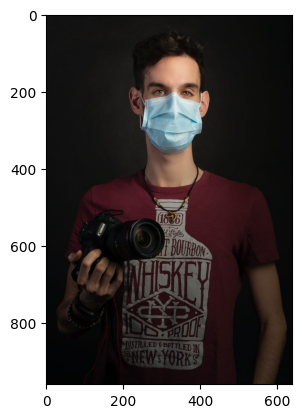

In [7]:
# 读取
img = cv2.imread('./test_imgs/mask_people.jpg')
# 显示图片
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

## 2、裁剪人脸

In [20]:
# 加载SSD模型
face_detector = cv2.dnn.readNetFromCaffe('./weights/deploy.prototxt.txt','./weights/res10_300x300_ssd_iter_140000.caffemodel')

In [22]:
# 转为Blob
img_blob = cv2.dnn.blobFromImage(img,1,(300,300),(104,177,123),swapRB=True)

In [23]:
# 输入
face_detector.setInput(img_blob)

In [24]:
# 推理
detections = face_detector.forward()

In [25]:
detections.shape

(1, 1, 200, 7)

In [26]:
# 人数
person_count = detections.shape[2]

In [27]:
person_count

200

In [34]:
# 人脸检测得函数
def face_detec(img):
    # 转为Blob
    img_blob = cv2.dnn.blobFromImage(img,1,(300,300),(104,177,123),swapRB=True)
    # 输入
    face_detector.setInput(img_blob)
    # 推理
    detections = face_detector.forward()
    # 遍历结果
    # 获取原图尺寸
    img_h,img_w = img.shape[:2]
    # 人脸数量
    person_count = detections.shape[2]
    for face_index in range(person_count):
        # 置信度
        confidence = detections[0,0,face_index,2]
        # print(confidence)
        if confidence > 0.5:
            locations = detections[0,0,face_index,3:7] * np.array([img_w,img_h,img_w,img_h])
            # print(locations)
            # 取整
            l,t,r,b = locations.astype('int')
            # cv2.rectangle(img,(l,t),(r,b),(0,255,0),5)
            return img[t:b,l:r]
    return None

In [80]:
img_new = cv2.imread('./images/1.yes/0_0_0 copy 52.jpg')

In [81]:
face_crop = face_detec(img_new)

In [82]:
face_crop.shape

(245, 216, 3)

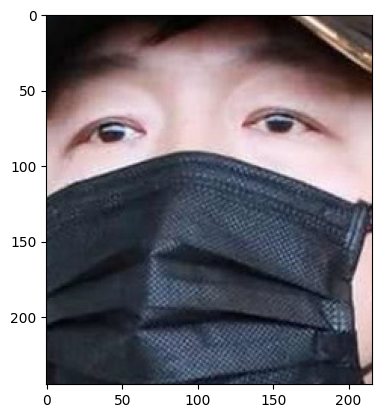

In [83]:
plt.imshow(cv2.cvtColor(face_crop,cv2.COLOR_BGR2RGB))

### 3、转为Blob图像

In [108]:
# 转为blob得函数
def imgBlob(img):
    # 转为Blob
    img_blob = cv2.dnn.blobFromImage(img,1,(100,100),(104,177,123),swapRB=True)
    # 压缩维度
    img_squeeze = np.squeeze(img_blob).T
    # 旋转
    img_rotate = cv2.rotate(img_squeeze,cv2.ROTATE_90_CLOCKWISE)
    # 镜像
    img_flip = cv2.flip(img_rotate,1)
    # 去除负数并归一化
    img_blob = np.maximum(img_flip,0) / img_flip.max()
    
    return img_blob

In [109]:
img_test = cv2.imread('./images/1.yes/0_0_0 copy 52.jpg')

In [110]:
img_blob = imgBlob(img_test)

In [111]:
img_blob.max(),img_blob.min()

(1.0, 0.0)

In [112]:
img_blob.shape

(100, 100, 3)

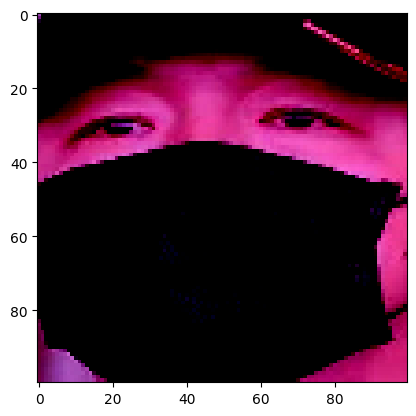

In [113]:
plt.imshow(img_blob)

## 4、处理所有图片

In [133]:
# 获取图片类别标签labels
import os,glob

In [134]:
import tqdm # 显示处理过程的函数

In [135]:
labels = os.listdir('./images/')

In [136]:
labels

['1.yes', '2.no', '3.nose']

In [137]:
# 遍历所有类别
# 两个列表保存结果
img_list = []
label_list = []

for label in labels:
    # 获取文件列表
    file_list = glob.glob('./images/%s/*.jpg' % (label))
    # print(len(file_list))
    for img_file in tqdm.tqdm(file_list,desc = '处理 %s' % (label)):
        # 读取文件
        img = cv2.imread(img_file)
        # 裁剪人脸
        img_crop = face_detec(img)
        # 判断为空得情况 
        if img_crop is not None:
            # 转为blob
            img_blob = imgBlob(img_crop)
            img_list.append(img_blob)
            label_list.append(label)
            # print(label)

处理 3.nose: 100%|█████████████████████████████████████████████████████████████████| 1919/1919 [01:11<00:00, 26.77it/s]


## 5、保存为numpy文件

In [141]:
# 转为numpy数组
X = np.asarray(img_list)
Y = np.asarray(label_list)

In [142]:
X.shape,Y.shape

((5328, 100, 100, 3), (5328,))

In [143]:
# 存储为numpy文件
np.savez('./data/imageData.npz',X,Y)